<a href="https://colab.research.google.com/github/ritwikraha/computer-needs-glasses/blob/master/image-multimodal-models/Nougat_Scientific_Understanding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q pymupdf python-Levenshtein nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 109.0 MB/s eta 0:00:00


In [2]:
import re
import torch

from PIL import Image
from huggingface_hub import hf_hub_download
from transformers import NougatProcessor, VisionEncoderDecoderModel
from transformers.image_utils import load_image

In [3]:
processor = NougatProcessor.from_pretrained("facebook/nougat-base")
model = VisionEncoderDecoderModel.from_pretrained("facebook/nougat-base")

preprocessor_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.49k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.14M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.77k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.40G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/165 [00:00<?, ?B/s]

In [4]:
%%capture
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

In [17]:
url = 'https://huggingface.co/datasets/ritwikraha/random-storage/resolve/main/sample-mathematics.png'

In [18]:
image = load_image(url)
pixel_values = processor(image, return_tensors="pt").pixel_values

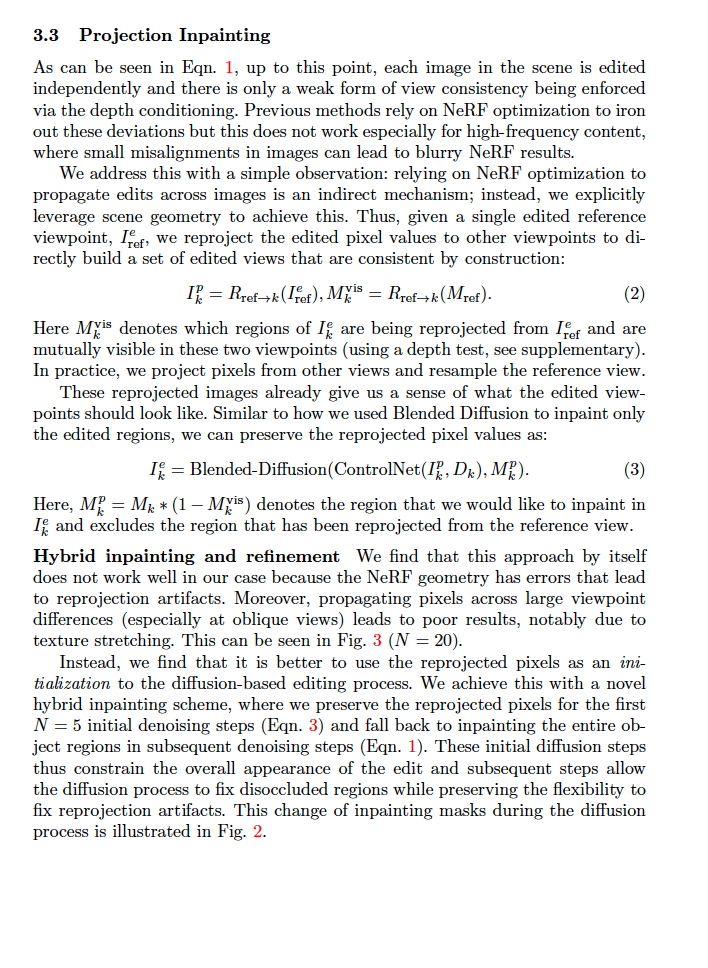

In [19]:
# show the original image
image

In [20]:
# generate transcription
outputs = model.generate(
    pixel_values.to(device),
    min_length=1,
    max_length=4000,
    bad_words_ids=[[processor.tokenizer.unk_token_id]],
)

In [21]:
sequence = processor.batch_decode(outputs, skip_special_tokens=True)[0]
sequence = processor.post_process_generation(sequence, fix_markdown=False)
print(sequence)



### Projection Inpainting

As can be seen in Eqn. 1, up to this point, each image in the scene is edited independently and there is only a weak form of view consistency being enforced via the depth conditioning. Previous methods rely on NeRF optimization to iron out these deviations but this does not work especially for high-frequency content, where small misalignments in images can lead to blurry NeRF results.

We address this with a simple observation: relying on NeRF optimization to propagate edits across images is an indirect mechanism; instead, we explicitly leverage scene geometry to achieve this. Thus, given a single edited reference viewpoint, \(I^{e}_{\text{ref}}\), we reproject the edited pixel values to other viewpoints to directly build a set of edited views that are consistent by construction:

\[I^{p}_{k}=R_{\text{ref}\to k}(I^{e}_{\text{ref}}),M^{\text{vis}}_{k}=R_{\text {ref}\to k}(M_{\text{ref}}).\] (2)

Here \(M^{\text{vis}}_{k}\) denotes which regions of \(I^{e}_{k